<!--<div style=float:right><img src="assets/img/applied-logo_100px.png"></img></div>-->

#### Applied AI Internal Demo Project
## Feature Reduction with SVD

The project demonstrates using Singular Value Decomposition (SVD) for Feature Reduction.

# 01_FeatureReduction

+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load-Data)
    
    
+ [Brief Primer on Matrix Algebra](#Brief-Primer-on-Matrix-Algebra)


+ [Overview of Singuar Value Decomposition (SVD)](#Overview-of-Singuar-Value-Decomposition-[SVD])


+ [Worked Example Full SVD](#Worked-Example-Full-SVD)
    + [Choose $A$](#Choose-A)
    + [Create $U$](#Create-U)
    + [Create $V$](#Create-V)
    + [Create $S$](#Create-S)    
    + [Reconstruct $A$](#Reconstruct-A)
    
    
+ [Using SVD for Feature Reduction](#Using-SVD-for-Feature-Reduction)
    + [Load Iris Dataset and Visualise](#Load-Iris-Dataset-and-Visualise)
    + [Perform Feature Reduction](#Perform-Feature-Reduction)
    + [Visualise Reduced Dataset](#Visualise-Reduced-Dataset)
    
    
+ [Further Reading](#Further-Reading)

# Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Interactive magics - comment out if running from another script
%matplotlib inline
%qtconsole

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set(style='darkgrid', palette='muted')
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 10, 6
np.random.seed(0)

## Local Functions

In [3]:
def find_nice_A(shortcut=False, lim=1000000):
    """ 
    find a 'nice' original array A, such that the eigenvalues
    of U and V are integers.
    (require discriminant of the determinant characteristic eqn
        to be +positive perfect square)
    """
    if shortcut:
        A = np.array([[5, 0, 2, 4]
                     ,[2, 6, 1, 2]])
    else:
        A = np.random.randint(0,9,(2,4))
    
    roots = set(np.arange(50))

    for i in range(lim):
        U = A @ A.T

        a = 1
        b = - U[0,0] - U[1,1]
        c = (U[0,0] * U[1,1]) - (U[0,1] * U[1,0])

        if np.sqrt((b**2) - (4*a*c)) in roots:
            
            V = A.T @ A

            a = 1
            b = - V[0,0] - V[1,1]
            c = (V[0,0] * V[1,1]) - (V[0,1] * V[1,0])

            if np.sqrt((b**2) - (4*a*c)) in roots:
                
                if (np.sum(A==0) == 1) & (np.sum(A[0,:] - A[1,:]) == 0):
                
                    return A, i
    
        A = np.random.randint(0,9,(2,4))       

    return 'not found', lim

## Load Data

In [4]:
# None at present

---

# Brief Primer on Matrix Algebra

## Basic Matrix Algebra

Lets create $X$, an $m * n$ matrix with $m=2, n=3$. This matrix has 2 rows and 3 columns, and I'll use it as the representation of 2 row vectors, each described in 3 dimensions.

In [5]:
X = np.array([[1, 2, 3]
             ,[4, 5, 6]])
X

array([[1, 2, 3],
       [4, 5, 6]])

### Some things we might want to compute on $X$ are:
    
##### Scalar multiplication

This is simple 'item-wise' multiplication

In [14]:
X * 2

array([[ 2,  4,  6],
       [ 8, 10, 12]])

##### The transpose matrix $X^{T}$

This is just a 'folding' around the diagonal

In [15]:
Y = (X * 2).T
Y

array([[ 2,  8],
       [ 4, 10],
       [ 6, 12]])

##### Matrix Multiplication

For $X Y$, we take the inner product of the row vectors of $X$ and the column vectors of $Y$. Lets index the resulting matrix $XY$ as follows:

$$ X Y = \begin{bmatrix} xy_{11} & xy_{12} \\ xy_{21} & xy_{22} \end{bmatrix}$$

And we could work out each part of the $XY$ like:

$$ xy_{11} = \begin{bmatrix} 1 & 2 & 3 \end{bmatrix} \begin{bmatrix} 2 \\ 4 \\ 6 \end{bmatrix} = (1 * 2) + (2 * 4) + (3 * 6) = 28$$

and so on for $xy_{12}$ etc, until we arrive at the result:

$$ X Y = \begin{bmatrix} 28 & 64 \\ 64 & 154 \end{bmatrix}$$

We can use a numpy function `np.dot` to do this more easily:


In [12]:
np.dot(X, Y)

array([[ 42,  96],
       [ 96, 231]])

In fact, this is a Python 3.5 project so lets use the brand-new @ operator for matrix multiplication (https://docs.python.org/3/whatsnew/3.5.html#whatsnew-pep-465):

In [13]:
X @ Y

array([[ 42,  96],
       [ 96, 231]])

##### The Determinant

This is a function that operates on a square matrix $A$ to reduce it to a single number. 

$$|A| = \begin{vmatrix} a & b \\c & d\end{vmatrix} = ad - bc$$

The determinant is not defined for a non-square matrix, so lets remove a dimension for this bit only:

In [10]:
A = X[:,:2]
A

array([[1, 2],
       [4, 5]])

In [11]:
(A[0,0] * A[1,1]) - (A[0,1] * A[1,0])

-3

In fact, we can use a numpy function here too. Note the solver introduces floating point rounding:

In [12]:
np.linalg.det(A)

-2.9999999999999996

## Eigenvalues and Eigenvectors

An _eigenvector_ is a nonzero vector $\overrightarrow{v}$ that relates a square matrix $M$ to a scalar _eigenvalue_ $\lambda$:

$$M \overrightarrow{v} = \lambda \overrightarrow{v}$$

A method for finding $\overrightarrow{v}$ and $\lambda$ is to treat the above as a series of linear equations and solve (using the determinant):

$$ M = \begin{bmatrix} 1 & 2 \\ 4 & 3 \end{bmatrix} $$

##### Finding the eigenvalues $\lambda$:
 
$$ M \overrightarrow{v} = \lambda \overrightarrow{v} = \begin{bmatrix} 1 & 2 \\ 4 & 3 \end{bmatrix} \begin{bmatrix} v_{1} \\ v_{2} \end{bmatrix} = \lambda \begin{bmatrix} v_{1} \\ v_{2} \end{bmatrix}$$

We now treat each row as a part of a set of linear equations:

$$1v_{1} + 2v_{2} = \lambda v_{1} \\4v_{1} + 3v_{2} = \lambda v_{2}$$

... and rearrange:

$$(1 - \lambda)v_{1} + 2v_{2} = 0 \\4v_{1} + (3-\lambda) v_{2} = 0$$

Now we make use of of the necessary and sufficient condition that for this system to have a nonzero vector $\overrightarrow{v}$, the determinant of the coefficient matrix must be zero:

$$ \begin{vmatrix} (1 - \lambda) & 2 \\ 4 & (3 - \lambda)\end{vmatrix} = 0$$

Using the simple determinant calculation from before:

$$ (1 - \lambda) (3 - \lambda) -  (2 * 4)  = 0$$

$$ \lambda^{2} - 4\lambda - 5 = 0$$

$$ (\lambda + 1) (\lambda - 5) = 0$$

So the two eigenvalues for this matrix are $\lambda = -1$ and $\lambda =5$


##### Finding the eigenvectors $\overrightarrow{v}$:


We now plug our values for $\lambda$ back into an equation from above, and reduce:


Chosing the biggest eigenvalue first, i.e. setting $\lambda = 5$:

$$(1 - \lambda)v_{1} + 2v_{2} = (1 - 5)v_{1} + 2v_{2} = -4v_{1} + 2v_{2} = 0$$

This reduces to $2v_{1} = v_{2}$ which has infinite values, so by convention we'll select the smallest possible vector that satisfies the equation: 

$$\overrightarrow{v} = \begin{bmatrix} 1 \\ 2 \end{bmatrix}$$


Secondly, setting $\lambda = - 1$:

$$(1 - \lambda)v_{1} + 2v_{2} = (1 + 1)v_{1} + 2v_{2} = 2v_{1} + 2v_{2} = 0$$

This reduces to $v_{1} = v_{2}$ which has infinite values, so by convention we'll select the smallest possible vector that satisfies the equation:

$$\overrightarrow{v} = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$$


##### Completing the thought:

Going back to the original equation $M \overrightarrow{v} = \lambda \overrightarrow{v}$, we can show that for this matrix $M$, there are two eigenvalues and two eigenvectors:

$$ \begin{bmatrix} 1 & 2 \\ 4 & 3 \end{bmatrix} \begin{bmatrix} 1 \\ 2 \end{bmatrix} = 5 \begin{bmatrix} 1 \\ 2 \end{bmatrix} $$

and

$$ \begin{bmatrix} 1 & 2 \\ 4 & 3 \end{bmatrix} \begin{bmatrix} 1 \\ 1 \end{bmatrix} = -1 \begin{bmatrix} 1 \\ 1 \end{bmatrix} $$

---

# Overview of Singular Value Decomposition [SVD]

Forms of SVD were developed independently by various mathematicians around the turn of the 20th century (see [wikipedia article](https://en.wikipedia.org/wiki/Singular_value_decomposition#History)), and stated simply, it is a particular decomposition of an arbitrary matrix $A$ with $m$ rows and $n$ columns into a set of related matrices:

$$A = U S V^{T}$$

where:

$A$ is an arbitrary $m * n$ matrix (for our purposes we will assume the values are all real),  
$U$ is a $m * m$ orthonormal matrix of 'left-singular' (eigen)vectors of $AA^{T}$,  
$V^{T}$ is a $n * n$ orthonormal matrix of 'right-singular' (eigen)vectors of $A^{T}A$, &dagger;     
$S$ is a $m * n$ diagonal matrix of the square root of nonzero eigenvalues of $U$ _or_ $V$ &Dagger;, ordered by decreasing size.


&dagger; : the columns of $V$ are the eigenvectors, so they appear on the rows of $V^{T}$  
&Dagger; : it's a property that the nonzero eigenvalues of $U$ and $V$ are the same.


A very frequent use for SVD, and the primary use in this notebook is for **feature reduction**. That is, we can select the first $k$ eigenvalues in $S$ (where $k < n$) and use this subselection to reconstruct a 'thinner' or 'reduced' version of $A$, $A\prime = U\prime S\prime V\prime^{T}$, which has fewer columns (aka fewer features). By selecting the first $k$ eigenvalues we ensure that $A\prime$ retains a disproportionately high amount of the variance of $A$; we have in effect compressed the original information and represented it using fewer features.

This usage of SVD is very similar to Principal Components Analysis (PCA) and in fact several numerical software libraries actually use SVD under the hood for their PCA routines; for example `sklearn.decomposition.PCA` within `scikit-learn` in Python. 

Conventional PCA is an analytical method that requires us to calculate the covariance matrix $covA = A^{T}A/(n-1)$. I won't go into the similarities of PCA and SVD here, instead the interested reader may wish to read these very informative exchanges on Stack Overflow: http://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca.

Two points that do stand out though, are:
+ It's possible to perform a reduced-SVD (detailed below), which only needs us to calculate $U S V^{T}$ for the first $k < n$ features; this makes it far quicker to compute than the full covariance matrix as computed within PCA.
+ In the case that we have many more features than samples $n >> m$, $covA$ will be singular and cannot be inverted, thus SVD as more stable, linear algebraic method is often preferred.

Ultimately, we use the outputs of the SVD as:

+ The principal component values $U_{k<m}S_{k<m}$, a $m * k$ matrix describing each row in dataset in a more compact set of components which approximate the original full dimensions, and
+ The principal directions (or 'principal axes') as the columns of $V$, a $n * n$ matrix describing the rotation of the axes relative to the original vector space.


# Worked Example (Full SVD)

Lets step through a worked example of 'Full' SVD. In practice this Full version is computationally expensive, since we must calculate the full matricies $U_{mm}$, $S_{mn}$, and $V_{nn}^{T}$. The 'Reduced' or 'Truncated' versions of SVD are usually preferred, where we can preselect the top $k < n$ dimensions of interest and calculate $U_{mm}$, $S_{mk}$, and $V_{kk}^{T}$


**Along the way I'll also code the basic steps using the standard scientific Python libraries, so you can see how easily we can perform these calculations.**

## Choose $A$

Lets create a very simple matrix $A$. Perhaps this is two records of customer transactions at a supermarket, where we record the total number of items per category. You can easily see how in practice such a table could become very wide and over-specified, thus desirable to simplify.

e.g.

| CustomerID  | # fruit  |  # dairy |  # meat  |  # bakery |
|:--:|--:|--:|--:|--:|
| c1 | 5 | 0 | 2 | 4 |
| c2 | 2 | 6 | 1 | 2 |


which can be represented in matrix form:


$$A = \begin{bmatrix} 5 & 0 & 2 & 4\\ 2 & 6 & 1 & 2\end{bmatrix}$$

In [19]:
A, i = find_nice_A(shortcut=True)
A

array([[5, 0, 2, 4],
       [2, 6, 1, 2]])

## Create $U$

$$U = eig(AA^{T}) = eig(\begin{bmatrix} 5 & 0 & 2 & 4 \\ 2 & 6 & 1 & 2\end{bmatrix} \begin{bmatrix} 5 & 2 \\ 0 & 6 \\ 2 & 1 \\ 4 & 2\end{bmatrix}) = eig(\begin{bmatrix} 45 & 20 \\ 20 & 45\end{bmatrix})$$


In [20]:
AAT = A @ A.T
AAT

array([[45, 20],
       [20, 45]])

### Find the eigenvalues $\lambda$ and eigenvectors $\overrightarrow{v}$ of $AA^{T}$

##### Finding eigenvalues $\lambda$:
 
$$ AA^{T} \overrightarrow{v} = \lambda \overrightarrow{v} = \begin{bmatrix} 45 & 20 \\ 20 & 45 \end{bmatrix} \begin{bmatrix} v_{1} \\ v_{2} \end{bmatrix} = \lambda \begin{bmatrix} v_{1} \\ v_{2} \end{bmatrix}$$

We now treat each row as a part of a set of linear equations:

$$45v_{1} + 20v_{2} = \lambda v_{1} \\ 20v_{1} + 45v_{2} = \lambda v_{2}$$

... and rearrange:

$$(45 - \lambda)v_{1} + 20v_{2} = 0 \\ 20v_{1} + (45-\lambda) v_{2} = 0$$

Now we make use of of the necessary and sufficient condition that for this system to have a nonzero vector $\overrightarrow{v}$, the determinant of the coefficient matrix must be zero:

$$ \begin{vmatrix} (45 - \lambda) & 20 \\ 20 & (45 - \lambda)\end{vmatrix} = 0$$

Using the simple determinant calculation from before:

$$ (45 - \lambda) (45 - \lambda) -  (20 * 20)  = 0$$

$$ \lambda^{2} - 90\lambda +1625 = 0$$

This looks tricky, but I pre-prepared for the answer:

$$ (\lambda - 65) (\lambda - 25) = 0$$

So the two eigenvalues for this matrix are $\lambda = 65$ and $\lambda = 25$


In [21]:
lmbU, U = np.linalg.eig(AAT)
print('lambda1 = {:.0f}\nlambda2 = {:.0f}'.format(lmbU[0],lmbU[1]))

lambda1 = 65
lambda2 = 25


##### Finding eigenvectors $\overrightarrow{v}$:


We now plug our values for $\lambda$ back into an equation from above, and reduce:

Chosing the biggest eigenvalue first, i.e. setting $\lambda = 65$:

$$(45 - \lambda)v_{1} + 20v_{2} = (45 - 65)v_{1} + 20v_{2} = -20v_{1} + 20v_{2} = 0$$

This reduces to $v_{1} = v_{2}$ which has infinite values, so by convention we'll select the smallest possible vector that satisfies the equation: 

$$\overrightarrow{v} = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$$

Note that `numpy.linalg.eig` employs a further convention which is to return the eigenvectors normalised to unit length, 

$$1 = \sqrt(v_{1}^{2}+v_{2}^{2})$$


thus our first eigenvector becomes:

$$\overrightarrow{v} = \begin{bmatrix} \frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}} \end{bmatrix}$$


Secondly, setting $\lambda = 25$:

$$(45 - \lambda)v_{1} + 20v_{2} = (45 - 25)v_{1} + 20v_{2} = 20v_{1} + 20v_{2} = 0$$

This reduces to $v_{1} = -v_{2}$ which has infinite values, so by convention we'll select the smallest possible vector that satisfies the equation:

$$\overrightarrow{v} = \begin{bmatrix} 1 \\ -1 \end{bmatrix}$$

Note that the chosen directionality of the eigenvectors is arbitrary, and not guaranteed to be preserved, thus we could equally choose our solution to be $-v_{1} = v_{2}$, and it's actually this version that `numpy.linalg.eig` chooses:

$$\overrightarrow{v} = \begin{bmatrix} -1 \\ 1 \end{bmatrix}$$


Note again that `numpy.linalg.eig` employs a further convention which is to return the eigenvectors normalised to unit length, thus our second eigenvector becomes:

$$\overrightarrow{v} = \begin{bmatrix} -\frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}} \end{bmatrix}$$

In [22]:
print('v1:\n{}\n\nv2:\n{}'.format(U[:,0,None],U[:,1,None]))

v1:
[[ 0.70710678]
 [ 0.70710678]]

v2:
[[-0.70710678]
 [ 0.70710678]]


Note that our set of eigenvectors, $ \begin{bmatrix} 1 & -1 \\ 1 & 1 \end{bmatrix}$ is small and simple, and thus was trivial to convert into the required orthonormal form by hand:

$$ U = \begin{bmatrix} \frac{1}{\sqrt{2}} & -\frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} \end{bmatrix} = \begin{bmatrix} 0.707 & -0.707 \\ 0.707 & 0.707 \end{bmatrix}$$

However, for larger matricies this is likely to be difficult and we may wish to use e.g. the [Gram-Schmidt](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process) orthonormalization process. In our case, `numpy` does the heavy lifting, so I won't go into any more detail.

## Create $V$

$$V = eig(A^{T}A) = eig(\begin{bmatrix} 5 & 2 \\ 0 & 6 \\ 2 & 1 \\ 4 & 2\end{bmatrix} \begin{bmatrix} 5 & 0 & 2 & 4 \\ 2 & 6 & 1 & 2\end{bmatrix}) = eig(\begin{bmatrix} 29 & 12 & 12 & 24 \\ 12 & 36 & 6 & 12 \\ 12 & 6 & 5 & 10 \\ 24 & 12 & 10 & 20 \end{bmatrix})$$


In [23]:
ATA = A.T @ A
ATA

array([[29, 12, 12, 24],
       [12, 36,  6, 12],
       [12,  6,  5, 10],
       [24, 12, 10, 20]])

### Find the eigenvalues $\lambda$ and eigenvectors $\overrightarrow{v}$ of $A^{T}A$

This is the same procedure as for $AA^{T}$ above, so let save time and use `numpy`:

In [24]:
lmbV, V = np.linalg.eig(ATA)
print(lmbV)
print(V)

[  6.50000000e+01   2.50000000e+01  -5.79559478e-15   2.09774203e-16]
[[-0.61394061  0.42426407 -0.61048658  0.05525028]
 [-0.52623481 -0.84852814 -0.05087388  0.00460419]
 [-0.26311741  0.14142136  0.66172683  0.86371563]
 [-0.52623481  0.28284271  0.43224482 -0.50092067]]


In [25]:
V.T

array([[-0.61394061, -0.52623481, -0.26311741, -0.52623481],
       [ 0.42426407, -0.84852814,  0.14142136,  0.28284271],
       [-0.61048658, -0.05087388,  0.66172683,  0.43224482],
       [ 0.05525028,  0.00460419,  0.86371563, -0.50092067]])

Note that `numpy` has returned floating point approximations, so let's write out the $\lambda$ eigenvalues more clearly:

$$\lambda = 65 , 25 , 0 , 0 $$

You can see these are the same values returned by $eig(AA^{T})$, padded with zeros at the end.

Also for clarity lets write out $V^{T}$, note the columns of $V$ (thus the rows of $V^{T}$) are displayed in the same order as the eigenvalues $\lambda$:

$$ V^{T} = \begin{bmatrix} -.614 & -0.526 & -0.263 & -0.526 \\ 0.424 & -0.849 & 0.141 & 0.283 \\ -0.610 & -0.051 & 0.662 & 0.432 \\ 0.055 & 0.005 & 0.864 & -0.501 \end{bmatrix}$$



## Create $S$

To make $S$ we take the square-roots of the nonzero eigenvalues and place them on the diagonal of a matrix size $m * n$

$$ S = \begin{bmatrix} \sqrt{65} & 0 & 0 & 0 \\ 0 & \sqrt{25} & 0 & 0\end{bmatrix}$$

In [26]:
S = np.sqrt(np.diag(abs(lmbV))[:2,:])
S

array([[ 8.06225775,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  5.        ,  0.        ,  0.        ]])

## Reconstruct $A$

Lets put everything back together and check that our decomposition is valid:

$$A = U S V^{T}$$

$$\begin{bmatrix} 5 & 0 & 2 & 4\\ 2 & 6 & 1 & 2\end{bmatrix} = \begin{bmatrix} 0.707 & -0.707 \\ 0.707 & 0.707 \end{bmatrix} \begin{bmatrix} 8.062 & 0 & 0 & 0 \\ 0 & 5 & 0 & 0\end{bmatrix} \begin{bmatrix} -.614 & -0.526 & -0.263 & -0.526 \\ 0.424 & -0.849 & 0.141 & 0.283 \\ -0.610 & -0.051 & 0.662 & 0.432 \\ 0.055 & 0.005 & 0.864 & -0.501 \end{bmatrix} $$

Hmm. I think I'll spare us all a lot of algebra and use numpy for this:

In [27]:
reconA = np.round(U @ S @ V.T, 0)
reconA

array([[-5., -0., -2., -4.],
       [-2., -6., -1., -2.]])

Note the overall sign reversal, which is a side effect of the process, since the signs of the eigenvectors are not guaranteed stable. This affects the whole matrix though, so we can just multiply by -1 to find exactly $A$ again.


...  it looks like our decomposition works! 

---

# Using SVD for Feature Reduction

SVD is not a new technique, and is classically used in several fields including signal compression and information retreival. As such, there are routines built into `scipy` which do all the heavy lifting for us; they're also well tested and robustly engineered, and are capable of dealing with many sitations including very large and sparse matrices.

Now that we've seen the fundamentals, lets use SVD for something slightly more interesting: compressing the information in a real data source. We'll keep it very basic for now though, and use the classic `iris` dataset.

## Load Iris Dataset and Visualise

In [22]:
iris = sns.load_dataset("iris")
print(iris.shape)
iris.head()

(150, 5)


sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

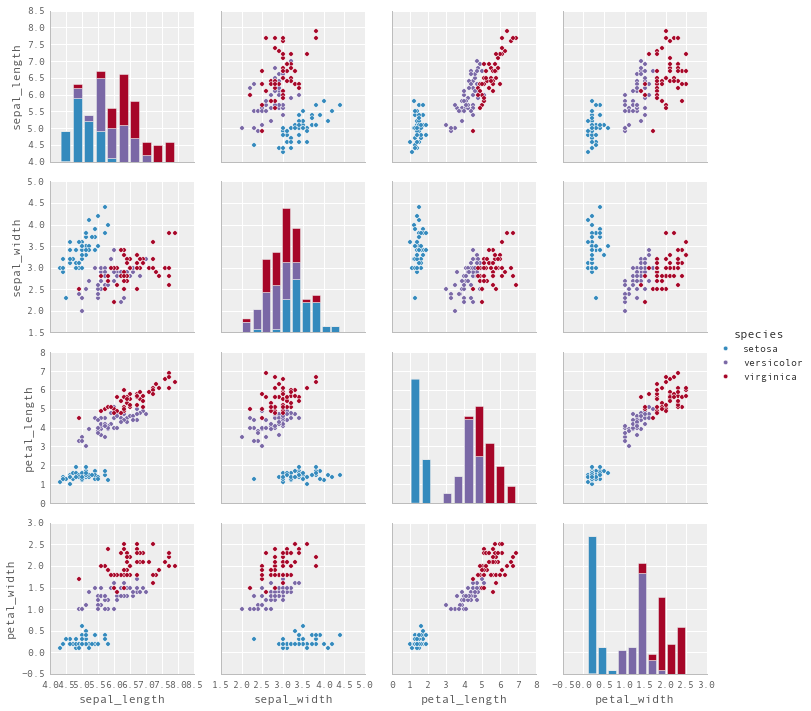

In [23]:
g = sns.pairplot(iris, hue="species")

**Observe:**

+ This dataset should be nothing new to our readers: 150 samples of iris flowers, each with 4 measurements of the flower body (sepals and petals)
+ The data is 4-dimensional, so in order to plot it on a 2D surface (without any clever transformations) we need to use a pairplot, resulting in a 4x4 matrix: a feat which `seaborn` makes very easy
+ Whilst we can see clusters of points according to species, the distinction is not always clear, and it would be useful to represent the data in a more compact way for plotting and further use.


## Perform Feature Reduction

In [24]:
from scipy.sparse.linalg import svds

In [25]:
## mean center and ensure we're only passing in numeric features to svd
u, s, vt = svds((iris - iris.mean()).iloc[:,:-1],2)

### Create the principal components $P = US$

In [26]:
pc = u @ np.diag(s)
pc = pc[:,::-1]

### Measure the retained variance

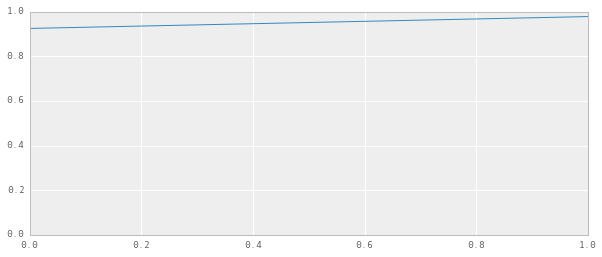

In [27]:
explained_variance = np.var(pc, axis=0)
full_variance = np.var((iris - iris.mean()).iloc[:,:-1], axis=0)
explained_variance_ratio = explained_variance / full_variance.sum()
ax = pd.Series(explained_variance_ratio.cumsum()).plot(
                    kind='line', figsize=(10,4)).set_ylim([0,1])

Because we've reduced to 2 features, there's actually only 2 points on this plot. Let's just print them out:

In [28]:
explained_variance_ratio.cumsum()

array([ 0.92461872,  0.97768521])

**Observe:**
+ Well that's pretty great! Using just two principal components we've retained 97.77% of the variance of the original 4-dimensional data
+ Note we could even reduce to a single component `c0` and retain 92.46% of the original varaince. This wouldn't produce a pretty scatterplot, but similar reductions to a single dimension can be useful for creating very simple decision boundaries for higher dimensional data.

## Visualise Reduced Dataset

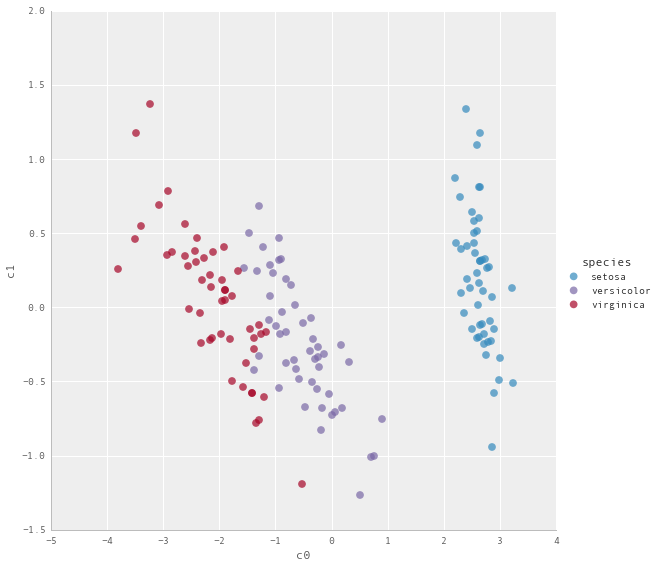

In [29]:
iris_svd = pd.concat((pd.DataFrame(pc, index=iris.index
                        , columns=('c0','c1')), iris.loc[:,'species']),1)

g = sns.lmplot('c0', 'c1', iris_svd, hue='species', fit_reg=False, size=8
              ,scatter_kws={'alpha':0.7,'s':60})

Observe:

+ We have reduced the information on each of the 150 flowers from the original 4 features to a compact representation in 2-dimensional space: the principal components `c0` and `c1`
+ We can plot the data in these two dimensions and see that the grouping is now more distinct and far easier for our eye to discern
+ These two components actually retain $97.77\%$ of the original variance, and the top component `c0` retains $92.46\%$ by itself
+ It's easy to imagine creating quite an efficient classifier for these flower species using just the single value for `c0`, a big reduction from the original 4 features.

# Further Reading

### Our blog at Applied AI

Earlier in the year I wrote a blogpost all about [Visualising High-Dimensional Data](http://blog.applied.ai/visualising-high-dimensional-data/), and used SVD for reducing a dataset from 147 original dimensions to just 50 principal components whilst preserving 98% of the original variance. Take a read through!

### Another great independent guide

My worked examples above were influenced by this helpful tutorial: http://www.ling.ohio-state.edu/~kbaker/pubs/Singular_Value_Decomposition_Tutorial.pdf

### Various Questions on Stack Exchange network

On CrossValidated - the stats network - see [this question](http://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca) on the relationship of PCA and SVD.

---
<!--<div style=float:right><img src=assets/img/applied-logo_100px.png></img></div>-->
**&copy; Applied AI Ltd 2015**  
<a href='http://www.applied.ai'>applied.ai</a>